In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,pow,log
import matplotlib.cm as cm
from scipy.integrate import quad
import h5py

In [2]:
!wget http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
d = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
z1 = d.T[1]
mu1 = d.T[2]
errmu= d.T[3]
dlabel = 'SCP_2.1'
label = {"Z_SN":z1,"DMdata_SN":mu1,"Error_DM_SN":errmu}
data_SN=pd.DataFrame(label)
#print(data_SN)
sort_data_SN=data_SN.sort_values(by=['Z_SN'],ignore_index=True)
!wget https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
cov_mat = np.genfromtxt('SCPUnion2.1_covmat_sys.txt')
z=sort_data_SN.Z_SN
mu=sort_data_SN.DMdata_SN

URL transformed to HTTPS due to an HSTS policy
--2022-02-06 13:24:05--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33899 (33K) [text/plain]
Saving to: ‘SCPUnion2.1_mu_vs_z.txt’

SCPUnion2.1_mu_vs_z 100%[===================>]  33.10K   104KB/s    in 0.3s    

2022-02-06 13:24:07 (104 KB/s) - ‘SCPUnion2.1_mu_vs_z.txt’ saved [33899/33899]

--2022-02-06 13:24:07--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6037238 (5.8M) [text/plain]
Saving to: ‘SCPUnion2.1_covmat_sys.txt’

SCPUnion2.1_covmat_ 100%[===================>]   5.76M  1.56MB/s    in 3.7s  

In [3]:
print(sort_data_SN)
print(z[1])
print(mu[1])

         Z_SN  DMdata_SN  Error_DM_SN
0    0.015000  34.163504     0.161453
1    0.015000  34.111411     0.213389
2    0.015000  34.379773     0.217349
3    0.015027  33.950192     0.178117
4    0.015100  34.525875     0.213682
..        ...        ...          ...
575  1.340000  45.067506     0.275015
576  1.350000  44.827065     0.185705
577  1.370000  45.049713     0.262748
578  1.390000  44.876234     0.250632
579  1.414000  44.803766     0.346181

[580 rows x 3 columns]
0.015
34.1114109643


In [4]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n,h0):
        if(omega_m<=0.0 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
        return loglikely


In [14]:
info = {
    "likelihood": {
        "external": lnl},
    "params": dict([
        ("omega_m", {
            "prior": {"min": 0, "max": 2.5},
            "latex": r"\Omega_m"}),
        ("n", {
            "prior": {"min": -5, "max": 4},
            "latex": r"n"}),
        ("h0", {
            "prior": {"min": 0, "max": 1.5},
            "latex": r"h0"}) ]),
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.01, 'max_tries':500}}}

In [15]:
from cobaya.run import run

updated_info, sampler = run(info)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 15.5}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:0.1053075, n:-3.55537, h0:1.445678
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-06 14:25:08 : 1 steps taken, and 0 accepted.


<ipython-input-4-8f1fdcbbcecc>:27: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
<ipython-input-4-8f1fdcbbcecc>:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  g = quad(int_func,0,z)


[mcmc] Progress @ 2022-02-06 14:26:08 : 1404 steps taken, and 23 accepted.
[mcmc] Progress @ 2022-02-06 14:27:08 : 2580 steps taken, and 43 accepted.
[mcmc] Progress @ 2022-02-06 14:28:08 : 3749 steps taken, and 53 accepted.
[mcmc] Progress @ 2022-02-06 14:29:08 : 5009 steps taken, and 75 accepted.
[mcmc] Progress @ 2022-02-06 14:30:08 : 6260 steps taken, and 95 accepted.
[mcmc] Progress @ 2022-02-06 14:31:09 : 7437 steps taken, and 114 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.015
[mcmc]  - Convergence of means: R-1 = 0.371704 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-02-06 14:32:09 : 8394 steps taken, and 224 accepted.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.038
[mcmc]  - Convergence of means: R-1 = 0.073554 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 360 samples 

[root] *WARNING* outlier fraction 0.016666666666666666 
Mean:
[0.11652101 0.35449541 0.6940346 ]
Covariance matrix:
[[ 4.42308329e-03 -4.07670133e-02  2.08806413e-04]
 [-4.07670133e-02  4.87343703e-01 -4.85250146e-03]
 [ 2.08806413e-04 -4.85250146e-03  1.70567762e-04]]


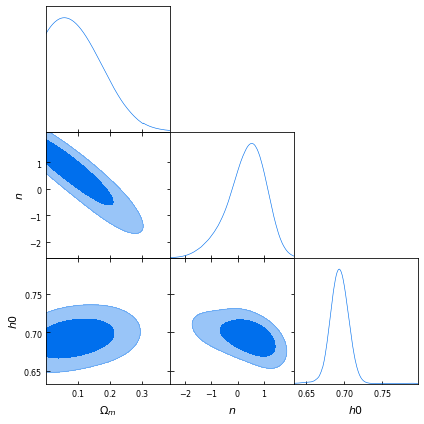

In [19]:
# Export the results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya

gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
# Analyze and plot
mean = gd_sample.getMeans()[:3]
covmat = gd_sample.getCovMat().matrix[:3, :3]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["omega_m", "n", "h0"], filled=True)

In [20]:
name=np.array(['GW190521','GW190706_222641','GW190413_134308','GW190514_065416','GW190719_215514','GW190521',"GW190909_114149","GW190413_052954",'GW190803_022701','GW190731_140936','GW190727_060333','GW190620_030421','GW190421_213856','GW170729','GW190602_175927','GW190527_092055','GW190519_153544','GW190424_180648','GW190929_012149','GW190828_063405','GW190701_203306','GW190513_205428','GW170823','GW190517_055101','GW190915_235702','GW190828_065509','GW190408_181802','GW190910_112807','GW190512_180714','GW190503_185404','GW190521_074359','GW170818','GW151012','GW170809','GW170104','GW190728_064510','GW190708_232457','GW190630_185205','GW190720_000836','GW190707_093326','GW190930_133541','GW190412','GW190924_021846','GW170814','GW151226','GW150914','GW190426_152155','GW200115_042309','GW170608','GW200105_162426','GW190814','GW190425','GW170817'])
full_DL_GW=np.array([[5300.0,2400,-2600],[4420.0,2590,-1930],[4450,2480,-2120],[4130.0,2650,-2170],[3940.0,2590,-2000],[3920.0,2190,-1950],[3770.0,3270,-2220],[3550.0,2270,-1660],[3270.0,1950,-1580],[3300.0,2390,-1720],[3300.0,1540,-1500],[2810.0,1680,-1310],[2880.0,1370,-1380],[2840.0,1400,-1360],[2690.0,1790,-1120],[2490.0,2480,-1240],[2530.0,1830,-920],[2200.0,1580,-1160],[2130.0,3650,-1050],[2130.0,660,-930],[2060.0,760,-730],[2060.0,880,-800],[1940.0,970,-900],[1860.0,1620,-840],[1620.0,710,-610],[1600.0,620,-600],[1550.0,400,-600],[1460.0,1030,-580],[1430.0,550,-550],[1450.0,690,-630],[1240.0,400,-570],[1060.0,420,-380],[1080.0,550,-490],[1030.0,320,-390],[990.0,440,-430],[870.0,260,-370],[880.0,330,-390],[890.0,560,-370],[790.0,690,-320],[770.0,380,-370],[760.0,360,-320],[740.0,140,-170],[570.0,220,-220],[600.0,150,-220],[450.0,180,-190],[440.0,150,-170],[370.0,180,-160],[300.0,150,-100],[320.0,120,-110],[280.0,110,-110],[241.0,41,-45],[159.0,69,-72],[40.0,7,-15]])
full_Z_GW=np.array([[0.82,0.28,-0.34],[0.71,0.32,-0.27],[0.71,0.31,-0.30],[0.67,0.33,-0.31],[0.64,0.33,-0.29],[0.64,0.28,-0.28],[0.62,0.41,-0.33],[0.59,0.29,-0.24],[0.55,0.26,-0.24],[0.55,0.31,-0.26],[0.55,0.21,-0.22],[0.49,0.23,-0.20],[0.49,0.19,-0.21],[0.49,0.19,-0.21],[0.47,0.25,-0.17],[0.44,0.34,-0.20],[0.44,0.25,-0.14],[0.39,0.23,-0.19],[0.38,0.49,-0.17],[0.38,0.10,-0.15],[0.37,0.11,-0.12],[0.37,0.13,-0.13],[0.35,0.15,-0.15],[0.34,0.24,-0.14],[0.3,0.11,-0.10],[0.3,0.10,-0.10],[0.29,0.06,-0.10],[0.28,0.16,-0.10],[0.27,0.09,-0.10],[0.27,0.11,-0.11],[0.24,0.07,-0.10],[0.21,0.07,-0.07],[0.21,0.09,-0.09],[0.2,0.05,-0.07],[0.2,0.08,-0.08],[0.18,0.05,-0.07],[0.18,0.06,-0.07],[0.18,0.10,-0.07],[0.16,0.12,-0.06],[0.16,0.07,-0.07],[0.15,0.06,-0.06],[0.15,0.03,-0.03],[0.12,0.04,-0.04],[0.12,0.03,-0.04],[0.09,0.04,-0.04],[0.09,0.03,-0.03],[0.08,0.04,-0.03],[0.07,0.03,-0.02],[0.07,0.02,-0.02],[0.06,0.02,-0.02],[0.053,0.009,-0.010],[0.04,0.01,-0.02],[0.01,0.00,-0.00]])
# Number of events
a=name.size

#Defining arrays
dldata_GW=np.zeros(a)
dlUP=np.zeros(a)
dlLOW=np.zeros(a)
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
Z_GW=np.zeros(a)
dmth_GW=np.zeros(a)
dmdata_GW=np.zeros(a)
dlth_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
b=c=d=e=f=h=k=l=m=x=y=p=q=r=s=0
#extracting redshifts and DL from the full data
for i in full_Z_GW:
  Z_GW[e]+=i[0]
  e+=1
for i in full_DL_GW:
  dldata_GW[b]+=i[0]
  b+=1
for i in dldata_GW:
  dmdata_GW[h]+=5*log(i,10)+25
  h+=1
for i in full_DL_GW:
  dlUP[c]+=i[0]+i[1]
  c+=1
for i in full_DL_GW:
  dlLOW[d]+=i[0]+i[2]
  d+=1
label1 = {"Event_Name":name,"Z_GW":Z_GW,"dLdata_GW":dldata_GW,"DMdata_GW": dmdata_GW,"DL_Uplimit": dlUP, "DL_Lowlimit": dlLOW}
data_GW=pd.DataFrame(label1)
data_GWTC3 = pd.read_excel (r'/root/Github_Repos/VCG_GW/oldGW.xlsx')
data_GWTC3.index= np.arange(53,88)

mucollect=[data_GW.Z_GW,data_GWTC3.redshift]
z1 = pd.concat(mucollect)

namecollect=[data_GW.Event_Name,data_GWTC3.Event_Name_GWTC3]
finalevents = pd.concat(namecollect)

dlcollect=[data_GW.dLdata_GW,data_GWTC3.luminosity_distance]
finaldl1 = pd.concat(dlcollect)

dlupcollect=[data_GW.DL_Uplimit,data_GWTC3.luminosity_distance_upper]
finaldlup1 = pd.concat(dlupcollect)

dllowcollect=[data_GW.DL_Lowlimit,data_GWTC3.luminosity_distance_lower]
finaldllow1 = pd.concat(dllowcollect)
label2 = {"EventName":finalevents,"ZGW":z1,"dLdataGW":finaldl1,"DLUplimit":finaldlup1,"DLLowlimit":finaldllow1}
Final_GW=pd.DataFrame(label2)
sort_data_GW=Final_GW.sort_values(by=['ZGW'],ignore_index=True)

z=sort_data_GW.ZGW
finaldl=sort_data_GW.dLdataGW
finaldlup=sort_data_GW.DLUplimit
finaldllow=sort_data_GW.DLLowlimit
a=finalevents.size

#Defining arrays
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
dmth3_GW=np.zeros(a)
mu=np.zeros(a)
dlth3_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
f=h=k=l=m=x=y=p=q=r=s=0

for i in finaldl:
  mu[h]+=5*log(i,10)+25
  h+=1
for i in finaldlup:
  dmtop[f]+=5*log(i,10)+25
  f+=1
for i in finaldllow:
  dmbottom[k]+=5*log(i,10)+25
  k+=1
#upper and lower differences for errors
for (i,j) in zip(mu,dmtop):
  dmtoperr[r]+=j-i
  r+=1
for (i,j) in zip(mu,dmbottom):
  dmbottomerr[s]+=i-j
  s+=1

In [21]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=(dmtoperr+dmbottomerr)/2
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02


#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n,h0):
        if(omega_m<=0.0 or omega_m>=1 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.dot(dmu,dmu)/np.dot(sigma,sigma)
        return loglikely

In [38]:
info = {
    "likelihood": {
        "external": lnl},
    "params": dict([
        ("omega_m", {
            "prior": {"min": 0, "max": 2.5},
            "latex": r"\Omega_m"}),
        ("n", {
            "prior": {"min": -5, "max": 4},
            "latex": r"n"}),
        ("h0", {
            "prior": {"min": 0, "max": 1.5},
            "latex": r"h0"}) ]),
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.0002, 'max_tries':10000}}}

In [39]:
from cobaya.run import run

updated_info, sampler = run(info)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 48100.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:2.240937, n:-3.131628, h0:0.2520775
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-06 16:35:09 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.393
[mcmc]  - Convergence of means: R-1 = 0.959489 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + conve

[mcmc]  - Acceptance rate: 0.283
[mcmc]  - Convergence of means: R-1 = 0.012947 after 3360 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4320 samples accepted.
[mcmc]  - Acceptance rate: 0.281
[mcmc]  - Convergence of means: R-1 = 0.006057 after 3456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4440 samples accepted.
[mcmc]  - Acceptance rate: 0.280
[mcmc]  - Convergence of means: R-1 = 0.008256 after 3552 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4560 samples accepted.
[mcmc]  - Acceptance rate: 0.281
[mcmc]  - Convergence of means: R-1 = 0.007541 after 3648 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4680 samples accepted.
[mcmc]  - Acceptance rate: 0.280
[mcmc]  - Convergence of means: R-1 = 0.008033 after 3744 accepted steps
[mcmc]  - Updated covariance m

[mcmc] Learn + convergence test @ 8760 samples accepted.
[mcmc]  - Acceptance rate: 0.273
[mcmc]  - Convergence of means: R-1 = 0.002503 after 7008 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8880 samples accepted.
[mcmc]  - Acceptance rate: 0.273
[mcmc]  - Convergence of means: R-1 = 0.003579 after 7104 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9000 samples accepted.
[mcmc]  - Acceptance rate: 0.272
[mcmc]  - Convergence of means: R-1 = 0.003562 after 7200 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9120 samples accepted.
[mcmc]  - Acceptance rate: 0.273
[mcmc]  - Convergence of means: R-1 = 0.003940 after 7296 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9240 samples accepted.
[mcmc]  - Acceptance rate: 0.272
[mcmc]  - Convergence of means: R-1 = 0.003884

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13320 samples accepted.
[mcmc]  - Acceptance rate: 0.274
[mcmc]  - Convergence of means: R-1 = 0.003991 after 10656 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13440 samples accepted.
[mcmc]  - Acceptance rate: 0.274
[mcmc]  - Convergence of means: R-1 = 0.003080 after 10752 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13560 samples accepted.
[mcmc]  - Acceptance rate: 0.274
[mcmc]  - Convergence of means: R-1 = 0.004166 after 10848 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13680 samples accepted.
[mcmc]  - Acceptance rate: 0.274
[mcmc]  - Convergence of means: R-1 = 0.004723 after 10944 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13800 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 17760 samples accepted.
[mcmc]  - Acceptance rate: 0.274
[mcmc]  - Convergence of means: R-1 = 0.002797 after 14208 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 17880 samples accepted.
[mcmc]  - Acceptance rate: 0.274
[mcmc]  - Convergence of means: R-1 = 0.002692 after 14304 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 18000 samples accepted.
[mcmc]  - Acceptance rate: 0.273
[mcmc]  - Convergence of means: R-1 = 0.002862 after 14400 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 18120 samples accepted.
[mcmc]  - Acceptance rate: 0.273
[mcmc]  - Convergence of means: R-1 = 0.002861 after 14496 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-02-06 16:40:09 : 65786 steps taken, and 18182 accepted.
[mcmc] Learn + convergence test @ 18240 samples a

[mcmc]  - Acceptance rate: 0.275
[mcmc]  - Convergence of means: R-1 = 0.001694 after 17760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22320 samples accepted.
[mcmc]  - Acceptance rate: 0.275
[mcmc]  - Convergence of means: R-1 = 0.001663 after 17856 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22440 samples accepted.
[mcmc]  - Acceptance rate: 0.275
[mcmc]  - Convergence of means: R-1 = 0.001759 after 17952 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22560 samples accepted.
[mcmc]  - Acceptance rate: 0.275
[mcmc]  - Convergence of means: R-1 = 0.001994 after 18048 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22680 samples accepted.
[mcmc]  - Acceptance rate: 0.275
[mcmc]  - Convergence of means: R-1 = 0.001743 after 18144 accepted steps
[mcmc]  - Updated cov

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 26760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001244 after 21408 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 26880 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001166 after 21504 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 27000 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001374 after 21600 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 27120 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001343 after 21696 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 27240 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 31200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.002141 after 24960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31320 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001941 after 25056 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31440 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001476 after 25152 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31560 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001804 after 25248 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31680 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000908 after 28512 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 35760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000836 after 28608 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 35880 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000831 after 28704 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 36000 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000744 after 28800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 36120 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000818 after 28896 accepted steps
[mcmc]  - Updated cov

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001000 after 32160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40320 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000923 after 32256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40440 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000774 after 32352 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40560 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000842 after 32448 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40680 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 44640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000740 after 35712 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 44760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000729 after 35808 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 44880 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000874 after 35904 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 45000 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001029 after 36000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 45120 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001287 after 39264 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001210 after 39360 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49320 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001150 after 39456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49440 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001076 after 39552 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49560 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000984 after 39648 accepted steps
[mcmc]  - Updated cov

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001044 after 42912 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000947 after 43008 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53880 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000946 after 43104 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 54000 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000964 after 43200 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 54120 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 58080 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000796 after 46464 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 58200 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000930 after 46560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 58320 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001032 after 46656 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 58440 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000970 after 46752 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 58560 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-02-06 16:49:10 : 226139 steps taken, and 62548 accepted.
[mcmc] Learn + convergence test @ 62640 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000977 after 50112 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 62760 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000940 after 50208 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 62880 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000937 after 50304 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 63000 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000867 after 50400 accepted steps
[mcmc]  - Updated covariance matrix of proposal 

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 67080 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000962 after 53664 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 67200 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000967 after 53760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 67320 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001056 after 53856 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 67440 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001161 after 53952 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 67560 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 71520 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001035 after 57216 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71640 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001061 after 57312 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71760 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001097 after 57408 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71880 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.001071 after 57504 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 72000 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000937 after 60768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 76080 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000800 after 60864 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 76200 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000716 after 60960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 76320 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000686 after 61056 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 76440 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000618 after 61152 accepted steps
[mcmc]  - Updated cov

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80520 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000494 after 64416 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000521 after 64512 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000603 after 64608 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80880 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000646 after 64704 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 81000 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 84960 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000304 after 67968 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 85080 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000302 after 68064 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 85200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000279 after 68160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 85320 samples accepted.
[mcmc]  - Acceptance rate: 0.276
[mcmc]  - Convergence of means: R-1 = 0.000269 after 68256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 85440 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000588 after 71520 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 89520 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000553 after 71616 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 89640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000539 after 71712 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 89760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000525 after 71808 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 89880 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000555 after 71904 accepted steps
[mcmc]  - Updated cov

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 93960 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001058 after 75168 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 94080 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001089 after 75264 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 94200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001074 after 75360 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 94320 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.001124 after 75456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 94440 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 98400 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000690 after 78720 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 98520 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000711 after 78816 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 98640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000704 after 78912 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 98760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000698 after 79008 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 98880 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000639 after 82272 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 102960 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000649 after 82368 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 103080 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000688 after 82464 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 103200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000605 after 82560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 103320 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000559 after 82656 accepted steps
[mcmc]  - Updated

[mcmc]  - Convergence of means: R-1 = 0.000440 after 85824 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 107400 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000367 after 85920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 107520 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000402 after 86016 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 107640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000396 after 86112 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 107760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000458 after 86208 accepted steps
[mcmc]  - Updated covariance matrix of proposal pd

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 111840 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000331 after 89472 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 111960 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000299 after 89568 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 112080 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000289 after 89664 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 112200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000289 after 89760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 112320 samples accepted.
[mcmc]  - Ac

[mcmc] Learn + convergence test @ 116280 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000369 after 93024 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 116400 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000367 after 93120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 116520 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000376 after 93216 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 116640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000359 after 93312 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 116760 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: 

[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000468 after 96576 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 120840 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000476 after 96672 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 120960 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000497 after 96768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 121080 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000549 after 96864 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 121200 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000550 after 96960 accepted steps
[mcmc]  - Updated

[mcmc]  - Convergence of means: R-1 = 0.000524 after 100128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 125280 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000518 after 100224 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 125400 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000510 after 100320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 125520 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000506 after 100416 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 125640 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000548 after 100512 accepted steps
[mcmc]  - Updated covariance matrix of propos

[mcmc]  - Convergence of means: R-1 = 0.000439 after 103680 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 129720 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000469 after 103776 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 129840 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000457 after 103872 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 129960 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000410 after 103968 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 130080 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000445 after 104064 accepted steps
[mcmc]  - Updated covariance matrix of propos

[mcmc]  - Convergence of means: R-1 = 0.000467 after 107232 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 134160 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000468 after 107328 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 134280 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000437 after 107424 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 134400 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000420 after 107520 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 134520 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000491 after 107616 accepted steps
[mcmc]  - Updated covariance matrix of propos

[mcmc]  - Convergence of means: R-1 = 0.000637 after 110784 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 138600 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000603 after 110880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 138720 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000642 after 110976 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 138840 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000596 after 111072 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 138960 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000553 after 111168 accepted steps
[mcmc]  - Updated covariance matrix of propos

[mcmc]  - Convergence of means: R-1 = 0.000598 after 114336 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 143040 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000578 after 114432 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 143160 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000588 after 114528 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 143280 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000600 after 114624 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 143400 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000619 after 114720 accepted steps
[mcmc]  - Updated covariance matrix of propos

[mcmc]  - Convergence of means: R-1 = 0.000545 after 117888 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 147480 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000540 after 117984 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 147600 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000528 after 118080 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 147720 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000554 after 118176 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 147840 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000558 after 118272 accepted steps
[mcmc]  - Updated covariance matrix of propos

[mcmc]  - Convergence of means: R-1 = 0.000290 after 121440 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 151920 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000297 after 121536 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 152040 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000276 after 121632 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 152160 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000242 after 121728 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 152280 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.000229 after 121824 accepted steps
[mcmc]  - Updated covariance matrix of propos

Mean: 
[ 0.49022626 -0.56882918  0.80678862]
Covariance matrix:
[[ 0.083532    0.01150818 -0.00810566]
 [ 0.01150818  6.71722339 -0.07092021]
 [-0.00810566 -0.07092021  0.09728727]]


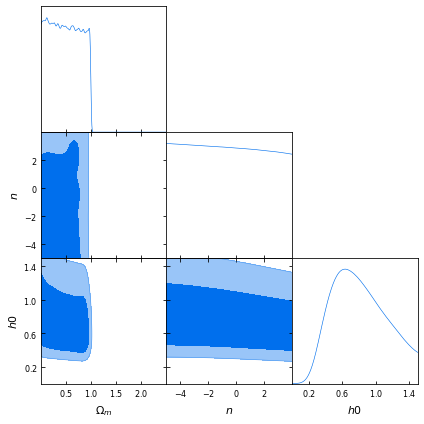

In [40]:
# Export the results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya

gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
# Analyze and plot
mean = gd_sample.getMeans()[:3]
covmat = gd_sample.getCovMat().matrix[:3, :3]
print("Mean: ")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["omega_m", "n", "h0"], filled=True)